In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
from pyro.infer.mcmc import NUTS, MCMC
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
def generate_data(nx=200, split=150, return_all=False):
    full_x = torch.linspace(-15., 15., nx)#.cuda()

    #sinc = lambda x: torch.sin(math.pi * x) / (math.pi * x)
    #sinc_testfn = lambda x: sinc(x) + sinc(x - 10.) + sinc(x + 10.)
    testfn = lambda x: torch.sin(math.pi * x * 0.05) * torch.exp(-0.15 * x.abs()) + \
                       torch.sin(math.pi * 2 * x * 0.1) * torch.exp(-0.15 * x.abs())

    full_y = testfn(full_x)

    if not return_all:
        train_set = ~((full_x > -4.5) * (full_x < 4.5))
        train_x = full_x[train_set]
        train_y = full_y[train_set]

        test_x = full_x[~train_set]
        test_y = full_y[~train_set]

        return train_x, train_y, test_x, test_y
    else:
        return full_x, full_y

train_x, train_y, test_x, test_y = generate_data(200, 150)


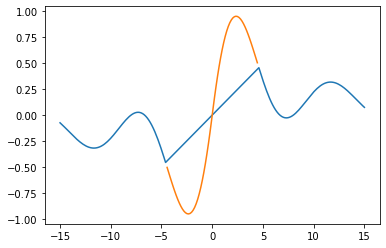

In [4]:
plt.plot(train_x.cpu(), train_y.cpu())
plt.plot(test_x.cpu(), test_y.cpu())

In [5]:
# We will use the simplest form of GP model, exact inference
class SpectralGPModel(gpytorch.models.PyroGP):
    def __init__(self, train_x, train_y, likelihood):
                # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )

        # Standard initializtation
        super(SpectralGPModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="fkl_regression_model"
        )
        self.likelihood = likelihood
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.keops.SpectralGPKernel(train_x, register_latent_params=True)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.QuadraticMean(input_size = 1, 
                        raw_quadratic_weights_constraint=gpytorch.constraints.LessThan(0.0),
                        raw_bias_constraint=gpytorch.constraints.Positive(), use_weights=False,
                        bias_prior=gpytorch.priors.LogNormalPrior(0., 0.3))
        
        self.mean_module.register_prior('quadratic_weights_prior',
                                       gpytorch.priors.LogNormalPrior(0., 0.3),
                                       lambda: -self.mean_module.quadratic_weights,
                                       lambda x: self.mean_module.initialize(**{'quadratic_weights': -x})
                                       )
        self.mean_module.quadratic_weights = -10.
        self.mean_module.bias = 1.

        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.MaternKernel(nu=1.5, 
                                    lengthscale_prior=gpytorch.priors.LogNormalPrior(0., 0.3)),
                                    outputscale_prior=gpytorch.priors.LogNormalPrior(0., 0.3),
                        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = SpectralGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
likelihood.register_prior("noise_prior", UniformPrior(1e-3, 0.3), "noise")

In [7]:
latent_lh = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
latent_lh.register_prior("latent_noise_prior", UniformPrior(1e-5, 1e-4), "noise")

latent_gp = ExactGPModel(model.covar_module.omega, model.covar_module.omega, latent_lh)
model.covar_module.register_prior("latent_gp_prior", gpytorch.priors.GaussianProcessPrior(latent_gp),
                                 "latent_params")

model.train()
model.pyro_sample_from_prior()

In [8]:
# this is for running the notebook in our testing framework
num_iter =  5000
num_particles = 30

def train():
    optimizer = pyro.optim.Adam({"lr": 1e-3})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.tqdm_notebook(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, noise=model.likelihood.noise.item())

train()

In [9]:
model.eval();

# this gp should probably always stay in prior mode
gp_model = model.covar_module.latent_gp_prior.gp_model
gp_model.train();

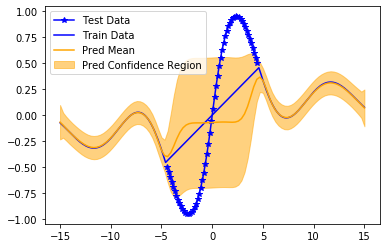

In [10]:
full_x = torch.linspace(-15., 15)
pred_dist = model(full_x)
conf_region = pred_dist.confidence_region()
pred_mean = pred_dist.mean.data

plt.plot(test_x.cpu(), test_y.cpu(), marker='*', label = 'Test Data', color = 'blue')
plt.plot(train_x.cpu(), train_y.cpu(), label = 'Train Data', color = 'blue')
plt.plot(full_x.cpu(), pred_mean.cpu(), label = 'Pred Mean', color = 'orange')
plt.fill_between(full_x.cpu(), conf_region[0].data.cpu(), conf_region[1].data.cpu(), color = 'orange',
                alpha = 0.5, label = 'Pred Confidence Region')
plt.legend()

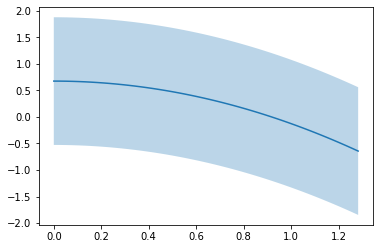

In [11]:
with torch.no_grad():
    omega = model.covar_module.latent_gp_prior.gp_model.train_inputs[0]
    gp_model = model.covar_module.latent_gp_prior.gp_model
    gp_model.train()
    spectral_dist = gp_model(omega)
    
spectral_c_region = [o.cpu().detach() for o in spectral_dist.confidence_region()]
plt.plot(omega.cpu(), spectral_dist.mean.cpu())
plt.fill_between(omega.cpu().view(-1), *spectral_c_region, alpha = 0.3)